# Nome: João José Cunha Melo e Sousa Bentivi

Neste projeto foi analizado como buscar uma boa seleção de alunos para receberem bolsas de estudos. Nele vimos deste a limpeza e analise dos dados como um todo (as correlações presentes no dado) até a ultilização de classificadores para o auxinio desta tarefa.

Também vimos como aperfeiçoar a acurácia ao modificar a analise dos parêmetros, em vez de tentar acertar a nota, tentamos acertar se ele estaria no top 25 por exemplo. Foi também analizado diferentes classificadores e até criado um.

# Pergunta: conferindo as versões utilizadas

In [1]:
import warnings
warnings.simplefilter("once")

!pip install pandas --upgrade
!pip install seaborn=="0.9.0" --quiet
!pip install scipy=="1.2.0" --quiet
!pip install yellowbrick=="0.9.0" --quiet
!pip install numpy=="1.16.0" --quiet

Requirement already up-to-date: pandas in /home/josebentivi/anaconda3/lib/python3.7/site-packages (0.24.1)


In [2]:
import pandas as pd
import seaborn as sns
import scipy
import yellowbrick
import numpy as np

print("Usando pandas %s" % pd.__version__)
print("Usando seaborn %s" % sns.__version__)
print("Usando scipy %s" % scipy.__version__)
print("Usando yellowbrick %s" % yellowbrick.__version__)
print("Usando numpy %s" % np.__version__)

/home/josebentivi/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/josebentivi/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/home/josebentivi/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
/home/josebentivi/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/josebentivi/anaconda3/lib/python3.7/importlib/_bootstrap

Usando pandas 0.24.1
Usando seaborn 0.9.0
Usando scipy 1.2.0
Usando yellowbrick 0.9
Usando numpy 1.16.0


In [3]:
# Vamos configurar o pandas para usar impressão de ponto flutuante com 3 casas decimais
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Pergunta: carregue os dados

In [4]:
# solução
enem = pd.read_csv("input/MICRODADOS_ENEM_2017.csv",sep=';',encoding='iso-8859-1',usecols=["NU_NOTA_CN",
                "NU_NOTA_CH","NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_COMP1", "NU_NOTA_COMP2", "NU_NOTA_COMP3",
                "NU_NOTA_COMP4", "NU_NOTA_COMP5"])

In [5]:
enem.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
0,445.400,589.000,621.500,465.500,140.000,120.000,120.000,100.000,80.000
1,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,604.000,610.400,563.900,591.200,140.000,120.000,140.000,100.000,80.000
4,482.100,569.200,570.800,584.600,140.000,120.000,120.000,120.000,80.000


In [6]:
print("%d elementos e %d colunas" % (enem.shape[0], enem.shape[1]))
if(enem.shape[0] != 6731341):
    print("ERRO! No conjunto de 2017 existem 6731341 dados")
if(enem.shape[1] != 9):
    print("ERRO! Carregue somente 9 colunas relativas as notas")

6731341 elementos e 9 colunas


# Pergunta: abra o arquivo DICIONARIO/Dicionário_Microdados_Enem_2017.xls

In [7]:
# solução
enem.columns = ['CN', 'CH', 'LC','MT','COMP1','COMP2','COMP3','COMP4','COMP5']

In [8]:
enem.head()

,CN,CH,LC,MT,COMP1,COMP2,COMP3,COMP4,COMP5
0,445.400,589.000,621.500,465.500,140.000,120.000,120.000,100.000,80.000
1,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,604.000,610.400,563.900,591.200,140.000,120.000,140.000,100.000,80.000
4,482.100,569.200,570.800,584.600,140.000,120.000,120.000,120.000,80.000


# Pergunta: alguns alunos e alunas não vieram na prova e possuem valores vazios.

In [9]:
# solução
enem = enem.dropna(axis=0)
enem["MT"].head()

0   465.500
3   591.200
4   584.600
5   578.500
6   607.500
Name: MT, dtype: float64

# Pergunta: analise a nota total

In [10]:
# solução e impressão
enem["nota_total"] = (enem["CN"]+enem["CH"]+enem["LC"]+enem["MT"]+enem["COMP1"]+enem["COMP2"]+enem["COMP3"]+
                    enem["COMP4"]+enem["COMP5"])
enem["nota_total"].head()

0   2681.400
3   2949.500
4   2786.700
5   2795.000
6   2858.500
Name: nota_total, dtype: float64

In [11]:
# solução histograma e descrição

import matplotlib.pyplot as plt
import nltk

def Histograma(dados):

    frequencia = nltk.FreqDist(dados["nota_total"])
    df_frequencia = pd.DataFrame({"Nota Total": list(frequencia.keys()),
                                 "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Nota Total", n = 10)
    df_frequencia

    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x= "Nota Total", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()

/home/josebentivi/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


/home/josebentivi/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):


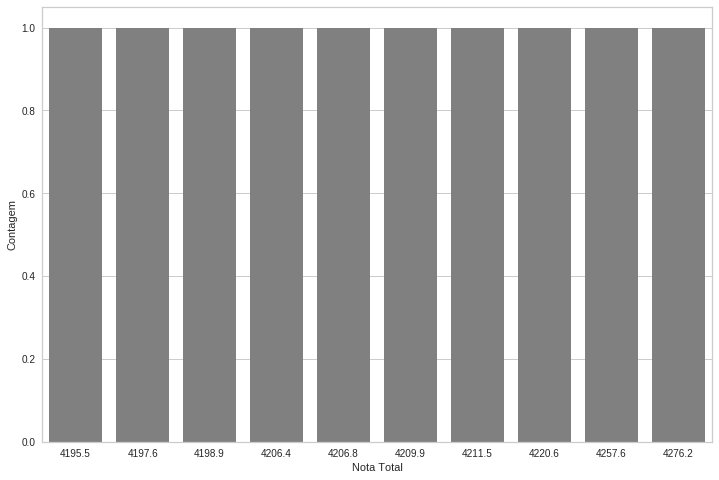

In [12]:
 Histograma(enem)

In [13]:
def InfoNotaTotal(dados):

    media = dados["nota_total"].mean()
    mediana = dados["nota_total"].median()
    desvio_padrao = dados["nota_total"].std()
    print("Média: "+ str(media) +" Mediana: "+str(mediana)+" Desvio padrão: "+str(desvio_padrao))

In [14]:
InfoNotaTotal(enem)

Média: 2592.7466701454587 Mediana: 2569.3 Desvio padrão: 395.98987496996494


# Pergunta: extraia 1% dos dados para explorarmos

In [15]:
import matplotlib.pyplot as plt

# solução sua função de sampling

def eda_sample(enem):
    # seed
    SEED = 745
    np.random.seed(SEED)
    
    # 1% de sample em enem_eda
    enem_eda = enem.sample(frac=0.01, random_state=SEED)
    
    return enem_eda

In [16]:
# descreva a nota_total
enem_eda = eda_sample(enem)
print("Enem EDA sampling tem a distribuição")
InfoNotaTotal(enem_eda)

Enem EDA sampling tem a distribuição
Média: 2594.1860531309326 Mediana: 2572.8 Desvio padrão: 396.48273543586373


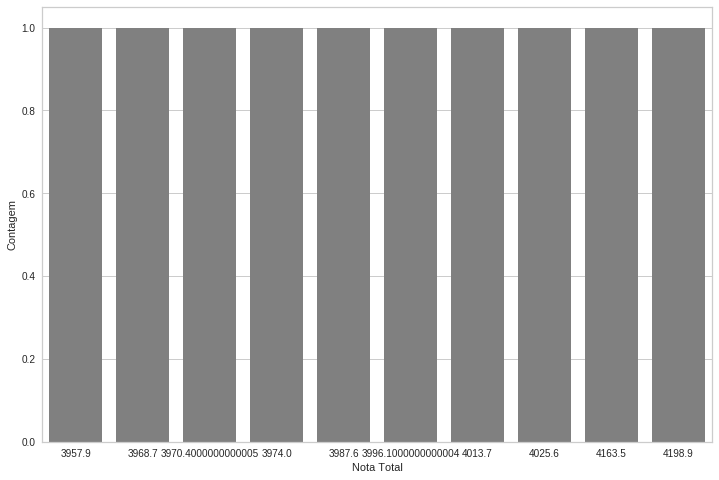

In [17]:
# plote o histograma da nota_total e mostre com plt.show()
Histograma(enem_eda)    

# Pergunta: analise a correlação entre as notas

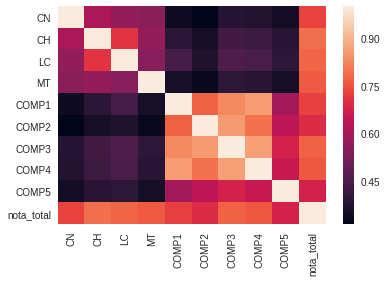

In [18]:
# solução
correlacoes = enem_eda.corr()

if(correlacoes.shape != (10,10)):
    print("A matriz de correlação deveria ser entre 10 notas, totalizando 10 linhas por 10 colunas")

sns.heatmap(correlacoes)

# Pergunta: analise a correlação da nota_total

In [19]:
# solução: cálculo da tabela de correlação com todas as notas

correlacao_com_nota_total = pd.DataFrame(correlacoes["nota_total"]).sort_values('nota_total', ascending=True)
print(correlacao_com_nota_total)

            nota_total
COMP5            0.675
COMP2            0.694
COMP1            0.726
CN               0.731
COMP4            0.760
MT               0.763
COMP3            0.774
LC               0.777
CH               0.792
nota_total       1.000


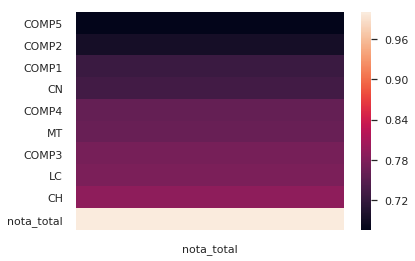

In [20]:
# solução gráfico
sns.set(style="white")
sns.heatmap(correlacao_com_nota_total)

# Pergunta: tente um primeiro modelo

In [21]:
# solução: definindo interesse e imprimindo os 5 primeiros elementos
interesse = enem_eda[["MT","LC","nota_total"]]
interesse.head()

,MT,LC,nota_total
3066813,418.700,514.900,2471.600
249978,652.200,466.100,2807.900
2399891,532.700,539.900,2577.300
3959805,578.500,647.300,3198.700
5505273,374.900,419.900,2247.700


In [22]:
# Solução: a função de split

from sklearn.model_selection import train_test_split

def split(dados):
    # seed
    SEED = 42367
    np.random.seed(SEED)
    X = dados.drop(columns="nota_total")
    Y = dados["nota_total"]
                   
    # train_test_split
    train_x, test_x , train_y , test_y = train_test_split(X,
                                         Y,test_size=0.2,random_state= SEED)
    
    print("*" * 80)
    print("Quebrando em treino (x,y) e teste (x,y)", train_x.shape, train_y.shape,test_x.shape, test_y.shape)
    print("Usando colunas %s como X" % str(train_x.columns.values))
    print("Desvio padrão do conjunto de testes", test_y.std())
    return train_x, test_x, train_y, test_y

In [23]:
# Código pronto

train_x, test_x, train_y, test_y = split(interesse)
if(train_x.shape[1]!=2):
    print("*" * 80)
    print("Erro! Você deveria possuir somente duas colunas em X")
    print("*" * 80)

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 2) (35414,) (8854, 2) (8854,)
Usando colunas ['MT' 'LC'] como X
Desvio padrão do conjunto de testes 396.6471089333878


# Pergunta: execute uma regressão linear

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [25]:
# Solução: função para executar a regressão linear

def roda_regressao_linear(train_x, test_x, train_y, test_y):
    
    # crie o modelo, treine com os dados de treino
    model = LinearRegression()
    model.fit(train_x, train_y)
    
    test_pred = model.predict(test_x)
    
    # calcule o r2_score com os dados de teste
    r2_score = model.score(test_x, test_y)
    
    # calcule a predição e os dois tipos de erros
    mse = mean_squared_error(test_y,test_pred)
    mae = mean_absolute_error(test_y,test_pred)
    
    
    print("*" * 80)
    print("r2 score", r2_score)
    print("mse", mse)
    print("mae", mae)
    
    return model

In [26]:
# código pronto

roda_regressao_linear(train_x, test_x, train_y, test_y)

********************************************************************************
r2 score 0.7684697385389772
mse 36422.29395376611
mae 141.98020024873023


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Pergunta: analise o erro médio absoluto

compare o erro médio absoluto com o desvio padrão dos estudantes do conjunto de testes

o que você achou do erro encontrado com o uso desse modelo linear?

# Solução

Comparando o erro médio absoluto com o desvio padrão do teste, vemos que o erro é alto, ao ponto que a nota "predita" pode estar espalhada no espectro das notas. Fugindo de muito da realidade.

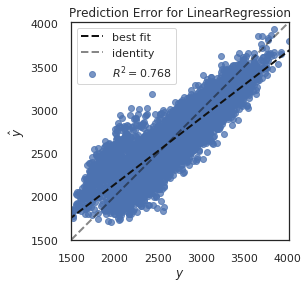

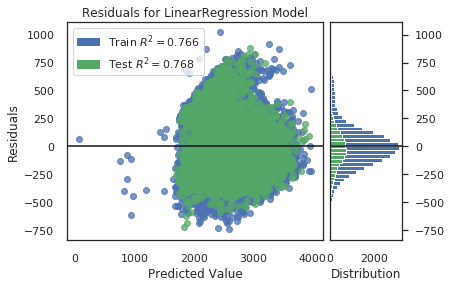

In [27]:
# código pronto
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

def visualiza_erros(train_x,train_y,test_x,test_y):
    visualizer = PredictionError(LinearRegression())
    visualizer.fit(train_x, train_y)
    visualizer.score(test_x, test_y)
    visualizer.poof()
    
    visualizer = ResidualsPlot(LinearRegression())
    visualizer.fit(train_x, train_y)
    visualizer.score(test_x, test_y)
    visualizer.poof()

visualiza_erros(train_x,train_y,test_x,test_y)

#solução 1: teste com todas as notas
#crie várias células com as combinações que julgar necessárias invocando sempre `regressao_completa_para`
#invoque ela com as notas que deseja analisar *E* a nota_total

# Explorando combinações de features

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 9) (35414,) (8854, 9) (8854,)
Usando colunas ['CN' 'CH' 'LC' 'MT' 'COMP1' 'COMP2' 'COMP3' 'COMP4' 'COMP5'] como X
Desvio padrão do conjunto de testes 396.6471089333878
********************************************************************************
r2 score 1.0
mse 1.7891377590098627e-25
mae 3.047485211751564e-13


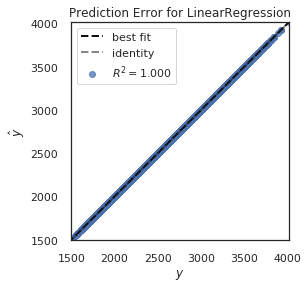

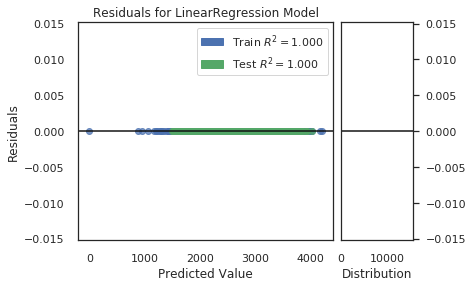

In [28]:
# solução 1: teste com todas as notas
# crie várias células com as combinações que julgar necessárias invocando sempre `regressao_completa_para`
# invoque ela com as notas que deseja analisar *E* a nota_total

train_x, test_x, train_y, test_y = split(enem_eda)
roda_regressao_linear(train_x, test_x, train_y, test_y)
visualiza_erros(train_x,train_y,test_x,test_y)

In [29]:
# código pronto

def regressao_completa_para(notas):
    SEED = 42367
    np.random.seed(SEED)
    
    interesse = enem_eda[notas]
    train_x, test_x, train_y, test_y = split(interesse)
    model = roda_regressao_linear(train_x, test_x, train_y, test_y)
    visualiza_erros(train_x,train_y,test_x,test_y)

Adicionando termos em sequância a partir dos mais proporcionais

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 1) (35414,) (8854, 1) (8854,)
Usando colunas ['CH'] como X
Desvio padrão do conjunto de testes 396.6471089333878
********************************************************************************
r2 score 0.6222179848624392
mse 59429.32694395436
mae 186.03733188430428


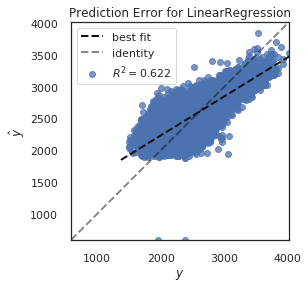

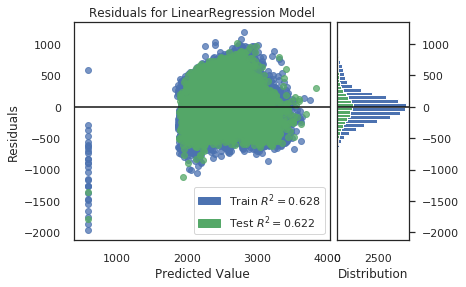

In [30]:
# solução 2: teste outra combinação
regressao_completa_para(["CH","nota_total"])

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 2) (35414,) (8854, 2) (8854,)
Usando colunas ['CH' 'LC'] como X
Desvio padrão do conjunto de testes 396.6471089333878
********************************************************************************
r2 score 0.7181555374323252
mse 44337.279283076445
mae 159.59042166984932


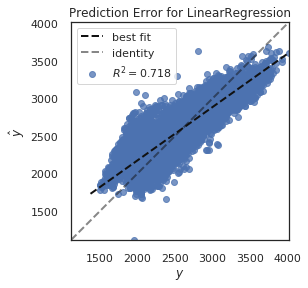

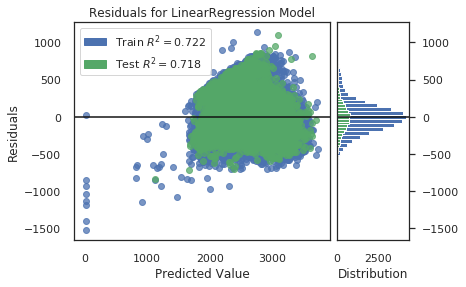

In [31]:
# solução 3: teste outra combinação
regressao_completa_para(["CH","LC","nota_total"])

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 3) (35414,) (8854, 3) (8854,)
Usando colunas ['CH' 'LC' 'COMP3'] como X
Desvio padrão do conjunto de testes 396.6471089333878
********************************************************************************
r2 score 0.8929377439226356
mse 16842.087671807894
mae 102.88829385794698


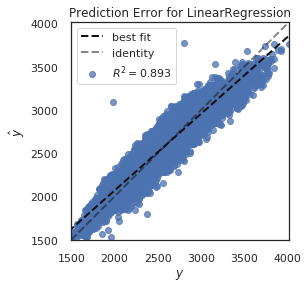

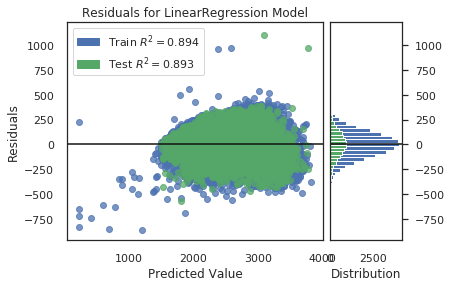

In [32]:
# solução 4: teste outra combinação
regressao_completa_para(["CH","LC","COMP3","nota_total"])

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 4) (35414,) (8854, 4) (8854,)
Usando colunas ['CH' 'LC' 'COMP3' 'MT'] como X
Desvio padrão do conjunto de testes 396.6471089333878
********************************************************************************
r2 score 0.9569814388936889
mse 6767.299739545645
mae 66.02423421705309


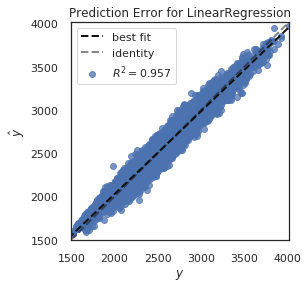

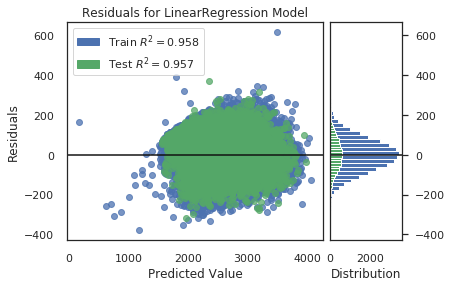

In [33]:
# solução 5: teste outra combinação
regressao_completa_para(["CH","LC","COMP3","MT","nota_total"])

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 8) (35414,) (8854, 8) (8854,)
Usando colunas ['CH' 'LC' 'COMP3' 'MT' 'COMP4' 'CN' 'COMP1' 'COMP2'] como X
Desvio padrão do conjunto de testes 396.6471089333878
********************************************************************************
r2 score 0.9929674610582241
mse 1106.296857103449
mae 26.196372607845127


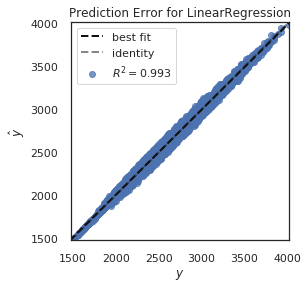

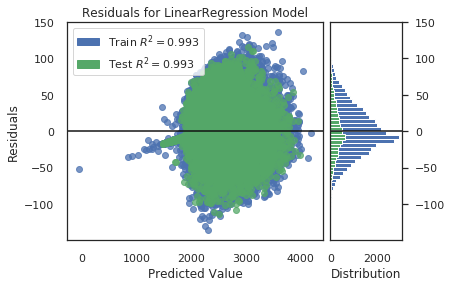

In [34]:
# solução 6: teste outra combinação
regressao_completa_para(["CH","LC","COMP3","MT","COMP4","CN","COMP1","COMP2","nota_total"])

Comparando com os dois ultimos valores

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 2) (35414,) (8854, 2) (8854,)
Usando colunas ['COMP5' 'COMP2'] como X
Desvio padrão do conjunto de testes 396.6471089333878
********************************************************************************
r2 score 0.5827883026284197
mse 65632.05598580278
mae 205.49837343386253


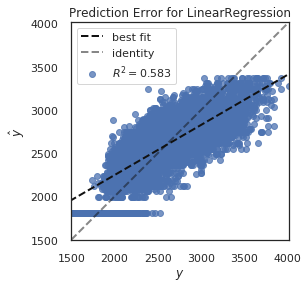

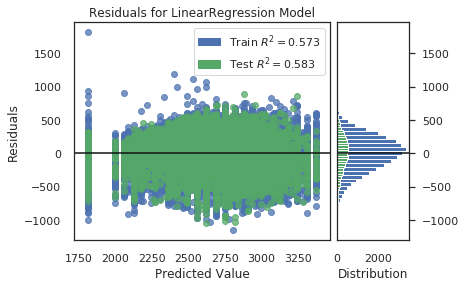

In [35]:
# solução 7: teste outra combinação
regressao_completa_para(["COMP5","COMP2","nota_total"])

Modelo especifico

# Pergunta: tente um modelo específico

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 3) (35414,) (8854, 3) (8854,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Desvio padrão do conjunto de testes 396.6471089333878
********************************************************************************
r2 score 0.9246894069541348
mse 11847.19673549339
mae 86.61916338036178


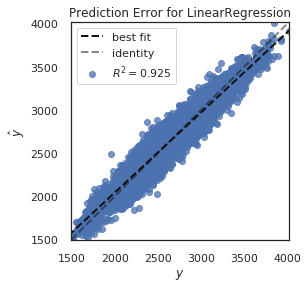

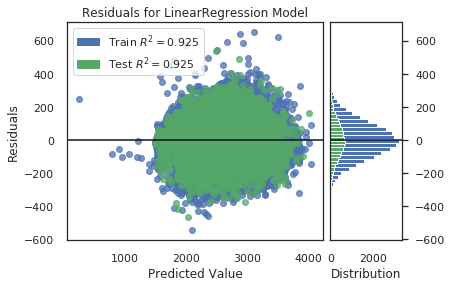

In [36]:
# solução
regressao_completa_para(["LC","MT","COMP3","nota_total"])

# Pergunta: Prepare diversos estimadores

In [37]:
# solução

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def gera_regressores():
    
    modelo0 = LinearRegression()
    modelo1 = Lasso()
    modelo2 = Ridge()
    modelo3 = DecisionTreeRegressor()
    modelo4 = RandomForestRegressor()
    modelos = [modelo0,modelo1,modelo2,modelo3,modelo4]
    
    return modelos

In [38]:
# teste

if(len(gera_regressores()) != 5):
    print("Erro!!! São 5 regressores que queremos testar!")

# Pergunta: crie uma função que escolhe parte dos dados

In [39]:
# solução

def escolhe_dados(dados, colunas):

    # extraia as colunas
    interesse = dados[colunas]
    
    # faça o split
    train_x, test_x, train_y, test_y = split(interesse)
    
    # plote o histograma de train_y
    frequencia = nltk.FreqDist(train_y)
    df_frequencia = pd.DataFrame({"Nota Total": list(frequencia.keys()),
                                 "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Nota Total", n = 10)
    df_frequencia

    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x= "Nota Total", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()
    
    return train_x, test_x, train_y, test_y

# Pergunta: treine e gere as métricas

In [40]:
# solução:

import time
def treina_e_mede_regressor(modelo, train_x, test_x, train_y, test_y):
    tic = time.time()
    # treine seu modelo
    modelo.fit(train_x,train_y)
    tac = time.time()
    tempo_de_treino = tac - tic

    # calcule a previsão para test_x
    modelo_pred = modelo.predict(test_x)
    
    # calcule o mse
    mse = mean_squared_error(test_y,modelo_pred)
    
    # calcule o mae
    mae = mean_absolute_error(test_y,modelo_pred)
    
    print("Resultado", modelo, mse, mae)

    return mse, mae, tempo_de_treino    

In [41]:
#código pronto

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def analisa_regressao(dados):
    train_x, test_x, train_y, test_y = escolhe_dados(dados, ["LC", "MT", "COMP3", "nota_total"])
    
    resultados = []
    for modelo in gera_regressores():
        
        # crie um pipeline chamado pipe usando StandardScaler() e o modelo
        scaler = StandardScaler()
        modelo_usado = modelo
        
        # use o make_pipeline ou crie um Pipeline
        pipe = Pipeline([('transformacao',scaler), ('estimador',modelo_usado)])
        
        mse, mae, tempo_de_treino = treina_e_mede_regressor(pipe, train_x, test_x, train_y, test_y)
        
        resultados.append([modelo, pipe, tempo_de_treino, mse, mae])
        
    resultados = pd.DataFrame(resultados, columns=["modelo", "pipe", "tempo_de_treino", "mse", "mae"])
    return test_x, test_y, resultados

********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (35414, 3) (35414,) (8854, 3) (8854,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Desvio padrão do conjunto de testes 396.6471089333878


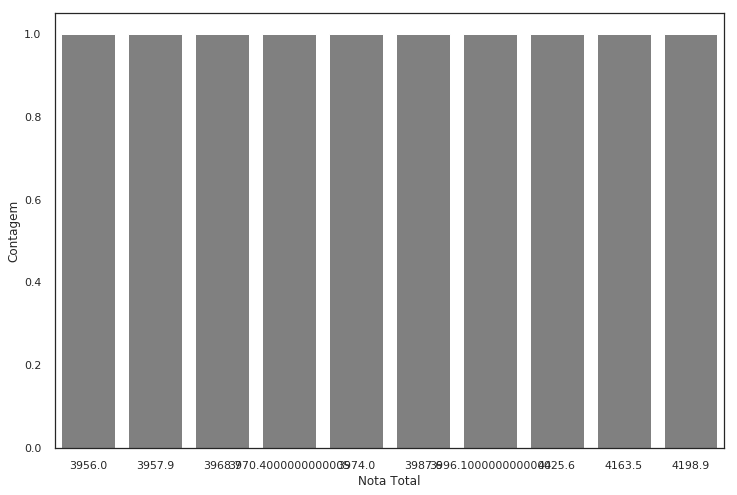

Resultado Pipeline(memory=None,
     steps=[('transformacao', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimador', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 11847.19673549339 86.61916338036178
Resultado Pipeline(memory=None,
     steps=[('transformacao', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimador', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]) 11844.626587825293 86.65055201582534
Resultado Pipeline(memory=None,
     steps=[('transformacao', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimador', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]) 11847.174928794242 86.61926944121045
Resultado Pipeline(memory=None,
     steps=[('transformacao', Stan

/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Resultado Pipeline(memory=None,
     steps=[('transformacao', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimador', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 14043.389774222887 93.70858877343574


,modelo,mse,mae,tempo_de_treino
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",11847.197,86.619,0.008
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",11844.627,86.651,0.387
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",11847.175,86.619,0.071
3,"DecisionTreeRegressor(criterion='mse', max_dep...",22492.422,118.699,0.195
4,"(DecisionTreeRegressor(criterion='mse', max_de...",14043.390,93.709,0.902


In [42]:
test_x, test_y, notas = analisa_regressao(enem_eda)
notas[["modelo", "mse", "mae", "tempo_de_treino"]]

# Pergunta: As notas de treino

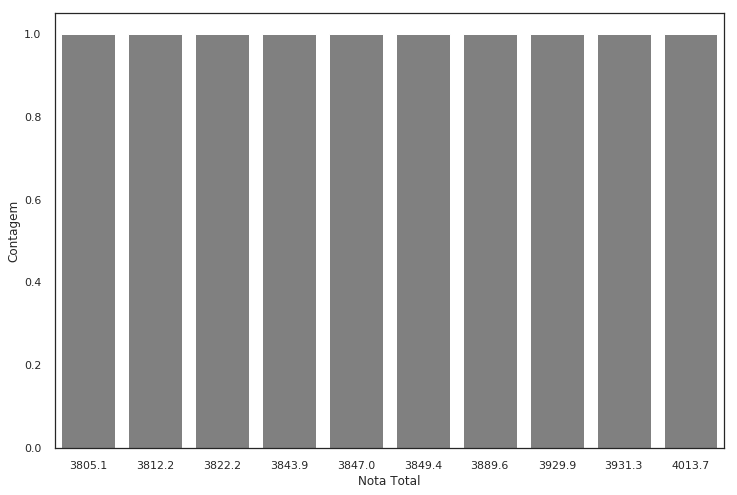

In [43]:
# solução: histograma
frequencia = nltk.FreqDist(test_y)
df_frequencia = pd.DataFrame({"Nota Total": list(frequencia.keys()),
                                 "Frequência": list(frequencia.values())})
df_frequencia = df_frequencia.nlargest(columns = "Nota Total", n = 10)
df_frequencia

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequencia, x= "Nota Total", y = "Frequência", color = 'gray')
ax.set(ylabel = "Contagem")
plt.show()

# Pergunta: criando as classes

In [44]:
# solução

def top_p(serie, p):
    # calcule o quantil p
    tamanho = len(serie)
    quant = round(tamanho*(1-p)+0.00001)
    print("quantile encontrado", quant)
    
    # defina y como sendo uma serie de 1s e 0s. 1 se o valor da serie for maior que o quantil, 0 se menor
    
    serie = serie.sort_values(ascending=True)
    
    x = serie.iloc[tamanho-quant]
  
    classificacao = list()
    chave = list()
    for item in serie:
        if item >= x:
            classificacao.append(1)
        else:
            classificacao.append(0)
            
    y = pd.Series(data=classificacao,index=serie.keys())
    
    return y   

In [45]:
top_25 = top_p(pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), p = 0.75).values
if(not np.array_equal(top_25, [0,0,0,0,0,0,0,1,1,1])):
    print("Não retornou o top 25% corretamente, deveria ser ", top_25)

quantile encontrado 3


In [46]:
# teste do top 10%

top_10 = top_p(pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), p = 0.90).values
if(not np.array_equal(top_10, [0,0,0,0,0,0,0,0,0,1])):
    print("Não retornou o top 10% corretamente, deveria ser", top_10)

quantile encontrado 1


In [47]:
# código pronto

y_top25 = top_p(test_y, 0.75)
y_top25.mean()

quantile encontrado 2214


0.25005647165123107

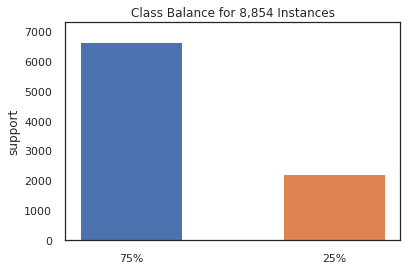

In [48]:
# código pronto

from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels=["75%", "25%"])
visualizer.fit(y_top25)
visualizer.poof()

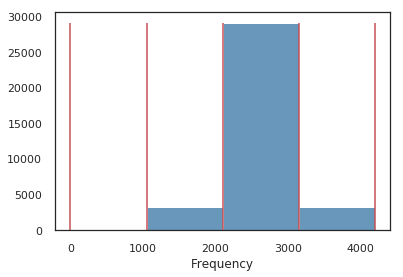

In [49]:
# código pronto

from yellowbrick.target import BalancedBinningReference

visualizer = BalancedBinningReference()
visualizer.fit(train_y)
visualizer.poof()

# Pergunta: Prepare diversos estimadores

In [50]:
# código pronto

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [51]:
# solução

def gera_classificadores():
    
    modelo0 = DummyClassifier()
    modelo1 = LogisticRegression()
    modelo2 = RidgeClassifier()
    modelo3 = DecisionTreeClassifier()
    modelo4 = RandomForestClassifier()
    modelo5 = SVC()
    
    modelos = [modelo0,modelo1,modelo2,modelo3,modelo4,modelo5]
    
    return modelos

In [52]:
# código pronto

if(len(gera_classificadores()) != 6):
    print("Erro!!! São 6 classificadores que queremos testar!")

# Pergunta: defina uma nova função de split, agora baseada nas classes

In [53]:
def split_classificacao(dados):
    # faça o seed do numpy
    SEED = 42367
    np.random.seed(SEED)
    
    # defina X como todas as colunas de `dados` exceto top_p
    X = dados.drop('top_p',axis=1)
  
    # defina y como somente a coluna top_p
    Y = dados["top_p"]
    # quebre em treino e teste, usando estratificação baseada em y
    
    x_treino, x_teste, y_treino, y_teste = train_test_split(X,Y, stratify=Y)
    
    print("*" * 80)
    print("Quebrando em treino (x,y) e teste (x,y)", x_treino.shape, y_treino.shape,x_teste.shape, y_teste.shape)
    print("Usando colunas %s como X" % str(x_treino.columns.values))
    print("Média do conjunto de testes", y_teste.mean())
    
    return x_treino, x_teste, y_treino, y_teste

In [54]:
# código pronto: teste

interesse = enem_eda[["nota_total", "LC", "MT", "COMP3"]]
interesse = interesse.sort_values("nota_total", ascending=True)
interesse['top_p'] = top_p(interesse['nota_total'],0.75)
interesse = interesse[["top_p", "LC", "MT", "COMP3"]]

train_x, test_x, train_y, test_y = split_classificacao(interesse)

if(train_x.shape[1] != 3):
    print("*" * 80)
    print("Erro! Você deveria possuir somente três colunas em X")
    print("*" * 80)

if(test_y.mean() <= 0.24 or test_y.mean() >= 0.26):
    print("*" * 80)
    print("Erro! Você deveria capturar somente o top 25% e usar estratificação no split")
    

quantile encontrado 11067
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.2500225896810337


# Pergunta: implemente o treino e o teste do classificador

In [55]:
# solução:

import time
def treina_e_mede_classificador(pipe, nome, train_x, test_x, train_y, test_y):
    tic = time.time()
    # treine o pipeline
    pipe.fit(train_x,train_y)
    tac = time.time()
    tempo_de_treino = tac - tic
    # calcule a accuracy_score
    accuracy_score = pipe.score(test_x,test_y)
    
    print("Resultado", nome, accuracy_score)

    return accuracy_score, tempo_de_treino

# Pergunta implemente a função de escolha de dados e split para classificação

In [56]:
# solução:

def escolhe_dados_para_classificacao(dados, colunas, p):
    interesse = dados[colunas] # selecione somente as colunas especificas de dados
    interesse = interesse.sort_values("nota_total", ascending=True)
    nota_total = interesse["nota_total"]# somente a coluna nota_total
    interesse['top_p'] = top_p(nota_total,p)# defina quem está no top p
    
    colunas.remove("nota_total")
    interesse = interesse[[*colunas, "top_p"]]
    
    train_x, test_x, train_y, test_y = split_classificacao(interesse)
    train_y.hist()
    plt.show()
    return train_x, test_x, train_y, test_y

quantile encontrado 11067
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.2500225896810337


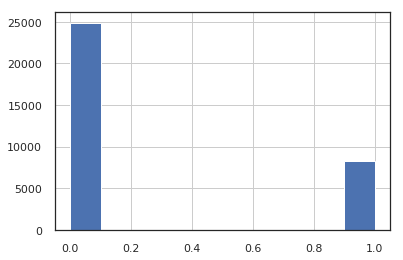

In [57]:
# testando a escolha

train_x, test_x, train_y, test_y = escolhe_dados_para_classificacao(enem_eda, ["nota_total", "LC", "MT", "COMP3"], p=0.75)

if(train_x.shape[1] != 3):
    print("*" * 80)
    print("Erro! Você deveria possuir somente três colunas em X")
    print("*" * 80)

if(test_y.mean() <= 0.24 or test_y.mean() >= 0.26):
    print("*" * 80)
    print("Erro! Você deveria capturar somente o top 25% e usar estratificação no split")
    print("*" * 80)

In [58]:
# código pronto

def analisa_classificacao(dados, p):
    
    colunas = ["nota_total", "LC", "MT", "COMP3"]
    train_x, test_x, train_y, test_y = escolhe_dados_para_classificacao(dados, colunas, p=p)
    
    resultados = []
    for modelo in gera_classificadores():
        nome = type(modelo).__name__
        pipe = make_pipeline(StandardScaler(), modelo)
        accuracy_score, tempo_de_treino = treina_e_mede_classificador(pipe, nome, train_x, test_x, train_y, test_y)
        resultados.append([nome, modelo, pipe, tempo_de_treino, accuracy_score])
        
    resultados = pd.DataFrame(resultados, columns=["tipo", "modelo", "pipe", "tempo_de_treino", "accuracy_score"])
    return test_x, test_y, resultados.set_index("tipo")

# Pergunta: rode a analisa_classificacao

quantile encontrado 11067
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.2500225896810337


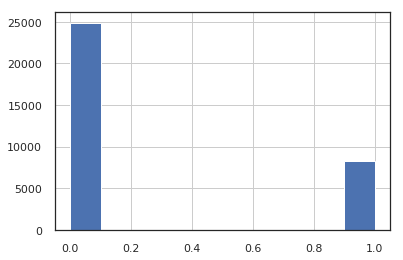

Resultado DummyClassifier 0.6217583807716635
Resultado LogisticRegression 0.9360260233125508


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Resultado RidgeClassifier 0.9222011385199241
Resultado DecisionTreeClassifier 0.9076533839342188


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Resultado RandomForestClassifier 0.9239179542784856
Resultado SVC 0.9365681756573597


,accuracy_score,tempo_de_treino
tipo,,
DummyClassifier,0.622,0.006
LogisticRegression,0.936,0.177
RidgeClassifier,0.922,0.043
DecisionTreeClassifier,0.908,0.116
RandomForestClassifier,0.924,0.306
SVC,0.937,10.059


In [59]:
# solução top 25%

# rode a analisa_classificacao e armazene test_x, test_y e notas
test_x,test_y,notas = analisa_classificacao(enem_eda, 0.75)
notas[["accuracy_score", "tempo_de_treino"]]

quantile encontrado 8854
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.2000542152344809


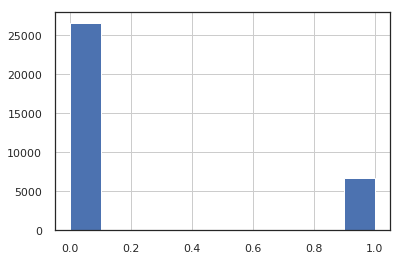

Resultado DummyClassifier 0.6796783229420801
Resultado LogisticRegression 0.9444293846570886
Resultado RidgeClassifier 0.9262672811059908


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Resultado DecisionTreeClassifier 0.9189482244510707


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Resultado RandomForestClassifier 0.9348513598987982
Resultado SVC 0.9437968735881449


,accuracy_score,tempo_de_treino
tipo,,
DummyClassifier,0.680,0.008
LogisticRegression,0.944,0.096
RidgeClassifier,0.926,0.014
DecisionTreeClassifier,0.919,0.099
RandomForestClassifier,0.935,0.277
SVC,0.944,7.455


In [60]:
# solução top 20%

# rode a analisa_classificacao e armazene test_x, test_y e notas
test_x,test_y,notas = analisa_classificacao(enem_eda, 0.80)
notas[["accuracy_score", "tempo_de_treino"]]

quantile encontrado 4427
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.10002710761724044


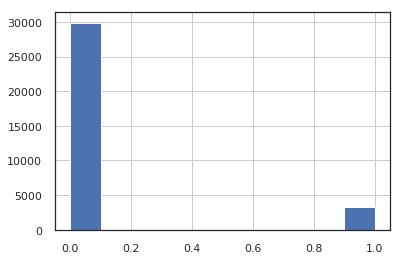

Resultado DummyClassifier 0.8219029547302792
Resultado LogisticRegression 0.9699105448631066
Resultado RidgeClassifier 0.928616607933496
Resultado DecisionTreeClassifier 0.9541881268636487


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Resultado RandomForestClassifier 0.9639468690702088
Resultado SVC 0.9702719797596457


,accuracy_score,tempo_de_treino
tipo,,
DummyClassifier,0.822,0.009
LogisticRegression,0.970,0.080
RidgeClassifier,0.929,0.013
DecisionTreeClassifier,0.954,0.078
RandomForestClassifier,0.964,0.233
SVC,0.970,3.936


In [61]:
# solução top 10%

# rode a analisa_classificacao e armazene test_x, test_y e notas
test_x,test_y,notas = analisa_classificacao(enem_eda, 0.90)
notas[["accuracy_score", "tempo_de_treino"]]

quantile encontrado 2213
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.04996837444655281


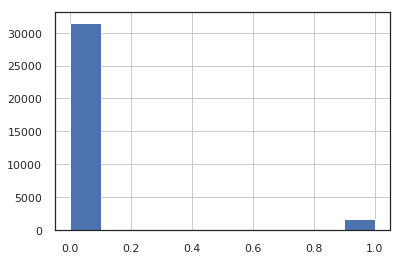

Resultado DummyClassifier 0.908105177554893
Resultado LogisticRegression 0.9827414836902503
Resultado RidgeClassifier 0.9500316255534472
Resultado DecisionTreeClassifier 0.9746091985181169


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Resultado RandomForestClassifier 0.97804283003524
Resultado SVC 0.9818378964489022


,accuracy_score,tempo_de_treino
tipo,,
DummyClassifier,0.908,0.008
LogisticRegression,0.983,0.076
RidgeClassifier,0.950,0.014
DecisionTreeClassifier,0.975,0.072
RandomForestClassifier,0.978,0.214
SVC,0.982,2.526


In [62]:
# solução top 5%

# rode a analisa_classificacao e armazene test_x, test_y e notas
test_x,test_y,notas = analisa_classificacao(enem_eda, 0.95)
notas[["accuracy_score", "tempo_de_treino"]]

quantile encontrado 443
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.01002981837896449


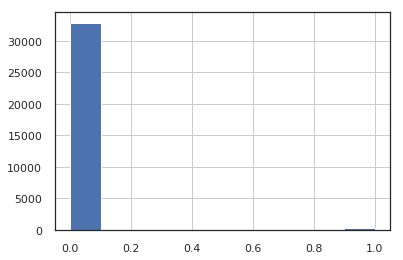

Resultado DummyClassifier 0.979940363242071
Resultado LogisticRegression 0.9942170416553718
Resultado RidgeClassifier 0.9899701816210356
Resultado DecisionTreeClassifier 0.9919580735520015


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Resultado RandomForestClassifier 0.9939459654829674
Resultado SVC 0.994126682931237


,accuracy_score,tempo_de_treino
tipo,,
DummyClassifier,0.980,0.007
LogisticRegression,0.994,0.079
RidgeClassifier,0.990,0.013
DecisionTreeClassifier,0.992,0.067
RandomForestClassifier,0.994,0.221
SVC,0.994,0.732


In [63]:
# solução top 1%

# rode a analisa_classificacao e armazene test_x, test_y e notas
test_x,test_y,notas = analisa_classificacao(enem_eda, 0.99)
notas[["accuracy_score", "tempo_de_treino"]]

quantile encontrado 33201
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.7499774103189663


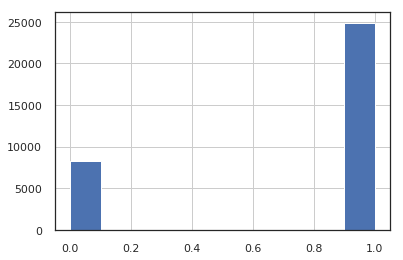

Resultado DummyClassifier 0.6264570344266739
Resultado LogisticRegression 0.9237372368302159
Resultado RidgeClassifier 0.9072919490376796


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Resultado DecisionTreeClassifier 0.8897623565555255


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Resultado RandomForestClassifier 0.9111773741754766
Resultado SVC 0.9254540525887774


,accuracy_score,tempo_de_treino
tipo,,
DummyClassifier,0.626,0.013
LogisticRegression,0.924,0.071
RidgeClassifier,0.907,0.014
DecisionTreeClassifier,0.890,0.099
RandomForestClassifier,0.911,0.282
SVC,0.925,12.038


In [64]:
# solução bottom 25%

# rode a analisa_classificacao e armazene test_x, test_y e notas
test_x,test_y,notas = analisa_classificacao(enem_eda, 0.25)
notas[["accuracy_score", "tempo_de_treino"]]

quantile encontrado 11067
********************************************************************************
Quebrando em treino (x,y) e teste (x,y) (33201, 3) (33201,) (11067, 3) (11067,)
Usando colunas ['LC' 'MT' 'COMP3'] como X
Média do conjunto de testes 0.2500225896810337


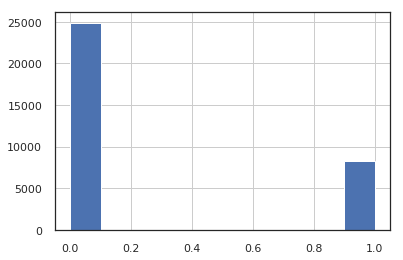

Resultado DummyClassifier 0.6217583807716635
Resultado LogisticRegression 0.9360260233125508
Resultado RidgeClassifier 0.9222011385199241
Resultado DecisionTreeClassifier 0.9076533839342188


/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/josebentivi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Resultado RandomForestClassifier 0.9239179542784856
Resultado SVC 0.9365681756573597


,accuracy_score,tempo_de_treino
tipo,,
DummyClassifier,0.622,0.010
LogisticRegression,0.936,0.073
RidgeClassifier,0.922,0.012
DecisionTreeClassifier,0.908,0.095
RandomForestClassifier,0.924,0.284
SVC,0.937,9.569


In [65]:
#  código pronto: rodando para top 25%

# rode a analisa_classificacao e armazene test_x, test_y e notas
test_x,test_y,notas = analisa_classificacao(enem_eda, 0.75)
notas[["accuracy_score", "tempo_de_treino"]]

In [66]:
# código pronto

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm):
    
    classes = ['Não topo 25%','Topo 25%']

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de confusão normalizada')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')
    plt.tight_layout()
    plt.show()

def print_confusion_for(test_x, test_y, model):
    pred_y = model.predict(test_x)
    print("Acurácia do modelo em teste", model.score(test_x, test_y))
    cnf_matrix = confusion_matrix(test_y, pred_y)

    plot_confusion_matrix(cnf_matrix)

Acurácia do modelo em teste 0.9360260233125508


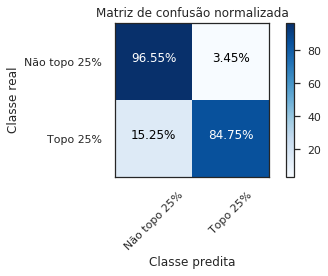

In [67]:
# código pronto

print_confusion_for(test_x, test_y, notas.loc['LogisticRegression']['pipe'])

Acurácia do modelo em teste 0.9365681756573597


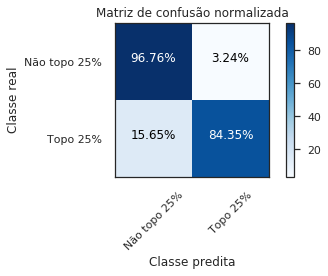

In [68]:
# código pronto

print_confusion_for(test_x, test_y, notas.loc['SVC']['pipe'])

In [69]:
# código pronto: separando os dados não usados para treino (que foram os usados em eda)

usados_no_eda = enem_eda.index
a_usar = ~enem.index.isin(usados_no_eda)
enem_validacao = enem[a_usar]
print("Para otimização temos %d elementos" % len(enem_validacao))
del(a_usar)
del(usados_no_eda)

Para otimização temos 4382487 elementos


In [70]:
enem_validacao = enem_validacao.sort_values("nota_total", ascending= True)

# Pergunta: separe os dados adequadamente de validação

In [71]:
def separa_dados_de_classificacao_para_validacao(dados):
    X = dados[["LC", "MT", "COMP3"]]# selecione as 3 colunas
    y = top_p(dados["nota_total"],0.75)# calcule o top 25% como 1 o bottom 75% como 0
    print("Média da validação", y.mean())
    return X, y

# Pergunta: defina uma função de validação cruzada de um modelo de classificação

In [72]:
# solução

from sklearn.model_selection import cross_val_score

def treina_e_valida_modelo_de_classificacao(dados, modelo):
    
    # calcule X e y usando a função anterior
    X,y = separa_dados_de_classificacao_para_validacao(dados)
    
    scores = cross_val_score(modelo, X, y,cv = 5, verbose=1)# calcule o cross_val_score
    mean = scores.mean()
    std = scores.std()
    print("Acurácia entre [%.2f,%.2f]" % (100*mean - 2*std, 100*mean + 2*std))
    
    
    x_treino,x_teste,y_treino,y_teste= train_test_split(X,y,stratify=y)
    
    modelo.fit(X, y)
    print_confusion_for(X, y, modelo)
    

quantile encontrado 1095622
Média da validação 0.2500075870162307


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.1s finished


Acurácia entre [88.55,88.99]
Acurácia do modelo em teste 0.935011786686418


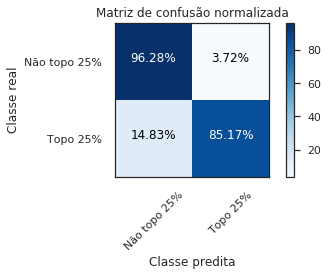

In [73]:
scaler = StandardScaler()
modelo_usado = LogisticRegression(solver='lbfgs')
        
pipeline_logistica = Pipeline([('transformacao',scaler), ('estimador',modelo_usado)])
treina_e_valida_modelo_de_classificacao(enem_validacao, pipeline_logistica)

# Pergunta: Implementando nosso estimador

In [74]:
# solução: implemente o código que falta

from sklearn.metrics import accuracy_score

class HeuristicaTop25:

    def fit(self, X, y = None):
        if(X.shape[1] != 3):
            print("Erro!!! Estávamos esperando 3 colunas!")
        
        parcial = X.sum(axis=1, skipna = True)
        self.top_25_quantile = pd.Series(parcial).quantile(0.75)
        print("top 25 quantile é %.2f" % self.top_25_quantile)
        return self

    def predict(self, X, y = None):
        parcial = X.sum(axis=1, skipna = True)# some por coluna
        y_pred_true_false = parcial.map(lambda x: x>=self.top_25_quantile.min()) # compare a soma parcial com o self.top25_quantile
        y_pred = (y_pred_true_false*1)# 1 se for maior ou igual, 0 caso contrário
        return y_pred

    def score(self, X, y = None):
        return accuracy_score(y, self.predict(X, y))

    def get_params(self, deep=True):
        return {}

quantile encontrado 1095622
Média da validação 0.2500075870162307


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


top 25 quantile é 1281.10
top 25 quantile é 1281.00
top 25 quantile é 1279.80
top 25 quantile é 1228.00
top 25 quantile é 1168.50


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.3s finished


Acurácia entre [92.70,93.22]
top 25 quantile é 1247.90
Acurácia do modelo em teste 0.9184453941335137


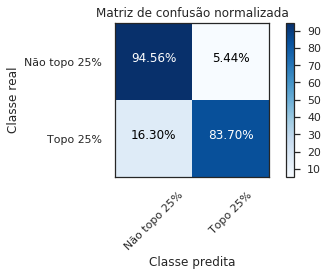

In [75]:
treina_e_valida_modelo_de_classificacao(enem_validacao, HeuristicaTop25())

# Pergunta: Compare os resultados da acurácia e da matriz de confusão entre (a) heurística final com (b) o DummyClassifier e (c) a LogisticRegression

Solução:

Valores da LogisticRegression

Acurácia do modelo em teste 0.9360260233125508


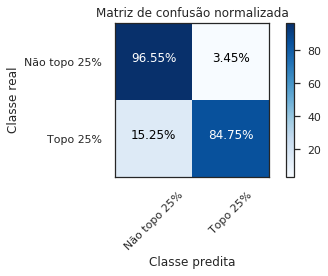

In [76]:
print_confusion_for(test_x, test_y, notas.loc['LogisticRegression']['pipe'])

Valores do DummyClassifier

Acurácia do modelo em teste 0.6254630884611909


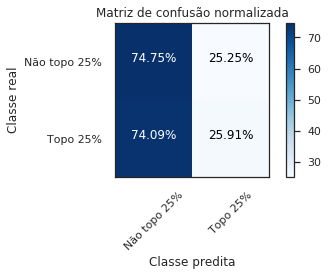

In [77]:
print_confusion_for(test_x, test_y, notas.loc['DummyClassifier']['pipe'])


Vemos que a LogisticRegression possui a melhor acurácia. Vemos também na matriz de confusão que no intervalo topo 25% ela possui uma melhora expressiva.


# Pergunta: Sugira uma outra heurística que poderia ser usada para tentar detectar facilmente o top 25%, sem a necessidade de um modelo complexo

Solução:

Selecionar os 25% dos alunos que fizeram a nota. Mesmo nao tendo uma acuracia perfeita, este metodo terá algum exito

# Pergunta: Se uma faculdade oferecer bolsa somente para quem o modelo julgar estar no top 25% o que acontece quando ele julga errôneamente que alguém não está no top 25%? E se julgar errôneamente que está no top 25%?

Solução:

Mesmo que o modelo erre, este erro é menor do que simplismente criar uma nota de corte a partir de uma certa valor da soma ou um metodo mais simples. Se avaliado o custo de uma bolsa de faculdade, mesmo se a melhora for de 1%, economizaria muito em valores absolutos. 